In [1]:
# para instalar wordcloud
#!pip install wordcloud 
import pandas as pd
import numpy as np
import re
import nltk
from collections import Counter
from utilidades import my_tokenizer, plotClusters
from matplotlib import pyplot as plt
import seaborn as sns
import wordcloud

# Análisis exploratorio en colecciones de  texto

Hasta ahora los conjuntos de datos que hemos utilizado han sido dato númericos o categoricos, con lo cual los datos son datos estructurado. Sin embargo en muchos problemas el conocimiento debe obtenerse a partir información no estructruradad como documentos de texto  o audio. Cuando lo anterior ocurre se hace necesario hacer uso de las técnicas de Procesamiento del Lenguaje Natural (PNL).

El procesamiento del lenguaje natural Es una rama de la ciencias computacionales y la inteligencia artificial que trata con el procesamiento del *lenguaje natural* como Inglés, Español, Japonés, etc. Este procesamiento generalamente consiste en transformar lenguaje natural en datos numéricos que pueden ser utilizados por una máquina para *aprender/visualizar*. El procesamiento generalmente involucra un flujo que puede estar constituido de muchos pasos y normalmete es llamado *pipeline*.

El objetivo es diseñar software  capaz de leer y procesar lenguaje natural para completar alguna tarea específica. Para nuestro curso principalmente trabajaremos con idioma Inglés y Español. Sin embargo las técnicas que revisaremos pueden ser utilizadas para cualqiuer idioma. A continuación se enumeran algunas categrias de posibles tareas que involucran procesamiento de lenguaje natural. 

|Búsqueda| Edición|Dialogo|Mineria de texto|Análisis de Sentimiento| Email|
|---------|--------|-------|----------------|----------------------|------|
|Web|Corrección|Chatbot|Resumenes|Monitoreo de opinión|Filtrado|
|Documentos|Grámtica|Asitente|Extracción de conocimiento|Reseñas|Clasificación|
|Automcompletado|Estilo|Scheduling|Diágnostico|Atención al cliente|Priorizado|

Para nuestro caso nos enfocaremos en la visualización de temas o tópicos, por lo que primero debemos transformar los documentos no estructurados en información númerica con lo cual obtendremos un modelos vectorial (Vector Space Mode VSM). Nuestro objetivo no es la generación de modelos sino simplemente realizar un análisis exploratorio por lo que solamente revisaremos brevemente las ideas detrás de algunos de los VSM más populares. 

## Conceptos preliminares

Para muchas tareas de PNL  se definen métodos que transformen el texto a un nuevo espacio dónde sea posible definir similitud en términos matemáticos (usalmente un espacio vectorial). Uno de los modelos  más populares es del denominado bolsa de palabras (bag-of-words), este método ya está impelmentados como parte de la librería  scikit-learn.

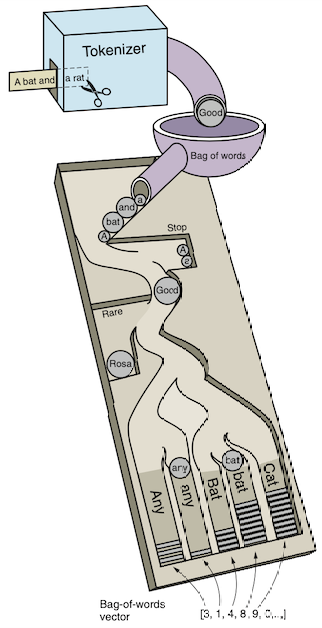
*Imagen Tomada de: Hapke, H. M., Lane, H., & Howard, C. (2019). Natural language processing in action* 


A groso modo el proceso para obtener el modelo consite en:

- Primero ser parte cada documento en términos normalizados(tokens). Una opción simple es dividir cada documento según los espacios en blanco y pasar todos los términos a minúsculas. (El tokenizador simple incluido en utilidades además remueve las stopwords my_tokenizer) 
- Crear un vocabulario a partir de todos los tokens que se generaron a partir de todos los documentos.
- Para cada documento se verifica si las palabras del vocabulario aparecen o no. Se genera un vector, donde cada entrada indica cuántas veces aparece un término del vocabulario en el documento (en su versión más simple un valor binario, 1 si aparece al menos una vez, 0 en caso contrario).

Este método genera un representación dispersa ya que cada documento contiene solo unas pocas palabras del vocabulario, por lo que la mayoría de entradas en el vector serían ceros. Esto resulta en una representación de alta dimensionalidad. Este método se llama bolsa de palabras porque el orden de las palabras se pierde completamente (solo sabemos qué aparecen).

Como ejmplo para ilustrar muchos de los conceptos utilizaremos el dataset de la competencia `HAHA@IberLEF2021: Humor Analysis based on Human Annotation`.

In [2]:
# Veamos la estructura del la infomación
# (esto es un comando de la terminal, no de python
# es muy probable que solo funcine en Linux o MAC)
!head  humor.csv

id,text,klass,humor_rating,humor_mechanism
tweet1,"Niveles de retraso mental: 

— Bajo.
— Medio.
— Alto.
— Elevado.
— Regresar con tu ex.",joke,1.5,
tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu odio, que perteneces al lado oscuro
—Señor súbase los pantalones o llamo a seguridad.


Vemos que los datos son delimitados por ",". Por lo que podemos cargalos como sigue:

In [3]:
data=pd.read_csv("humor.csv",delimiter=',',index_col=0) 

In [4]:
# vemos los datos 
data.head()

,text,klass,humor_rating,humor_mechanism
id,,,,
tweet1,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,joke,1.5,NaN
tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu ...",joke,1.5,NaN
tweet3,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",joke,2.6,NaN
tweet4,No se porqué me hago la cabeza deooos,no-joke,NaN,NaN
tweet5,Quisiera saber que hago durante la siesta de l...,no-joke,NaN,NaN


La clase esta definida por la columna **klass** como `joke` o `no-joke`, que tan gracioso es un chiste es un valor real entre 0 y 5, y es un NaN para los tweets que nos son chistes. La columna **humor\_mechanism** define es mecanismo utilizado para el chiste y puede ser cualquierea de los mostrados en la siguiente figura:

<AxesSubplot:>

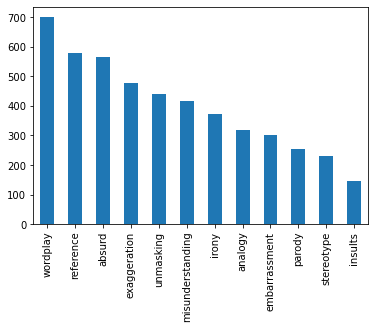

In [5]:
data.humor_mechanism.value_counts().plot(kind='bar')

<AxesSubplot:>

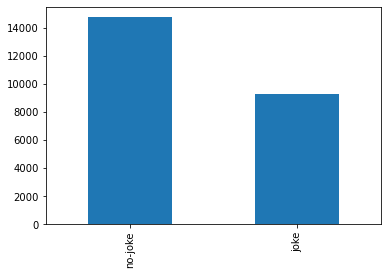

In [6]:
# podemos ver la distribucion por clases
data.klass.value_counts().plot(kind='bar')

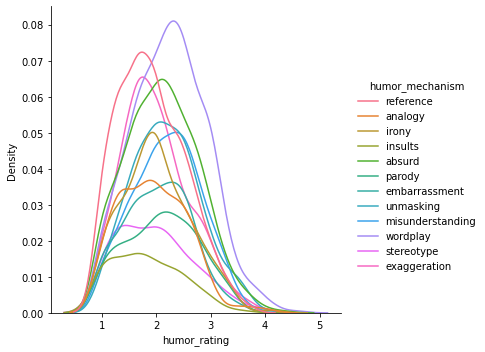

In [7]:
# podemos ver la distribucion por cada tipo de mecanismo
sns.displot(data, x='humor_rating', kind="kde", hue='humor_mechanism')

Todas las gráficas anteriores las producimos utilizando sola informción categorica que viene disponible en nuestro dataset, pero sin duda nos gustaría saber cuál es contenidos de cada tipo de tweet, que vocabulario los representa, que tan similares son uno de otros etc. Para esto es necesario procesar el texto para tranformarlo en un en tipo de datos en que podamos utilizar diferentes técnicas matemáticas y estadísticas. A continación describiremos de forma breve los elementos principales de un sistema de PLN.

## Vocabulario

El primer paso dentro del procesamiento de lenguage natural implica la construcción de un vocabulario. El objetivo es convertir secuencias de texto en unidades *minimas* de escritura con *significado* (tokens). Para este curso usaremos palabras y $n$-gramas. Sin embargo, las técnicas de preprocesamiento pueden ser extendidas facilmente a equaciones, emoticones o cualquier otra unidad de escritura.   

Como lidiamos con lenguaje escrito, la obtención de los tokens requiere manipulación de cadenas de caracteres. Se requiere identificar puntuación, signo diacríticos (dieresis, acententos), en el caso del Inglés es posible que se desee dividir las contracciones (You're -> you are). Una vez construido el vocabulario mediante la **tokenización** de todos los documentos, puede  realizarse una reducción del mismo mediante un proceso de **lematización** o **steamming**. Ya con el vocabulario es posible construir una representación vectorial. 

Note que la tokenización podría ser a nível de sufijos/prefijos, silabas o incluso letras, pero por el momento solo lidiaremos con palabras. También es posible construir unidades formadas por 2,3 o $n$ palabras, a esto tokens se les conoce como $n$-gramas y nos permitene incluir conceptos que de más de una unidad por ejemplo en inglés *ice cream*.

## Tokenizador

Es proceso de tokenizado es un proceso de segmentación de documentos. Donde la segmentación consiste dividir el texto (información no estructurada) en unidades más pequeñas que pueden ser contabilizadas de forma discreta. El resultado de la contabilización de las ocurrencias de cada término puede ser utilizada directamente como un representación vectorial del documento. Con lo cual se transforma una entrada de información no estructurada en información estructurada que puedes ser utilizada por algoritmos de aprendizaje automático. La aplicación más común de este tipo de vectores (bag of words) para recuperación de documentos o búsqueda.

Como parte de las librerías de python hay una amplia variedad de tokenizadores puede revisar las lista de los disponibles en la librería ntlk en `https://www.nltk.org/api/nltk.tokenize.html`. Uno conveniente para procesar tweets es `TweetTokenizer`

In [8]:
# podemos utilizarlo 
from nltk.tokenize import TweetTokenizer
tkz=TweetTokenizer()
#Para tokenizar el tweet0
tw0=tkz.tokenize(data.text.iloc[0])
tw1=tkz.tokenize(data.text.iloc[1])
tw2=tkz.tokenize(data.text.iloc[2])

Una forma básica de obtener una representación númerica de una secuencia de texto es mediante una representación binaria de cada token que existe en el vocabulario, está representación es conocida como **one-hot vectors**. Cada sentencia es representada como una lista de one-hot vectors por ejemplo:

In [9]:
## se ordena
vocabulario=list(set(tw0+tw1+tw2)) #solo contamos una vez cada término y es la unión de todos los documentos
vocabulario.sort() # lo ordenamos
n=len(vocabulario)
print(f"El tamaño del vocabulario: {n}")
print("El vocabulario:", vocabulario)

El tamaño del vocabulario: 58
El vocabulario: ['!', ',', '-', '.', '...', ':', '?', 'AGUA', 'Agua', 'Alto', 'Bajo', 'DIJE', 'Elevado', 'JAJAJA', 'Luke', 'Medio', 'Niveles', 'Pero', 'Regresar', 'Señor', 'Te', 'Vamos', 'a', 'al', 'algo', 'bien', 'café', 'con', 'corazón', 'creí', 'de', 'demuestra', 'desenfunda', 'entera', 'está', 'ex', 'lado', 'llamo', 'los', 'mental', 'mi', 'o', 'odio', 'ofrezco', 'oscuro', 'pantalones', 'perteneces', 'que', 'retraso', 'sable', 'seguridad', 'súbase', 'tu', 'vida', 'yo', '¡', '¿', '—']


Cada one-hot vector binaria será del tamaño del vocabulario y tendrá solo un 1 en la posición que corresponde a la palabra que representa.  

In [10]:
tw1_vector=[0 for i in range(n)]
tw1_map={}
for  word in tw1:
    tw1_vector[vocabulario.index(word )]=1
    tw1_map[word]=1

In [11]:
print(tw1_vector) # como puede observar hay muchos 0's

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]


los **one-hot-vectors** solo nos dicen si aparece o no una palabra en un documento, una modificación directa sería  utilizar un vector de frecuenacia por documentos como sigue:

In [12]:
tw2_vector=[0 for i in range(n)]
tw2_map={}
for  word in tw2:
    tw2_map[word]=tw2_map.get(word,0)+1
    tw2_vector[vocabulario.index(word)]=tw2_map[word]

In [13]:
print(tw2_vector)
print(tw2_map)

[1, 4, 4, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0]
{'-': 4, '¿': 2, 'Te': 1, 'ofrezco': 1, 'algo': 1, '?': 2, ',': 4, 'Agua': 2, 'café': 1, 'mi': 2, 'corazón': 1, 'vida': 1, 'entera': 1, 'está': 1, 'bien': 1, 'Pero': 1, 'yo': 1, 'creí': 1, 'que': 1, '...': 1, '¡': 1, 'AGUA': 1, 'DIJE': 1, '!': 1}


Como puede apreciar en ambos casos los vectores contienen muchos 0, por lo que las estrategías basadas en conteo de palabras utilizan una representación dispersa. Además tratan de mantener el vocabulario reducido, esto último de puede conseguir mediante el preprocesamiento del texto de entrada. El preprocesamiento puede incluir:

- Remover signos de puntuación
- Convertir todo el texto a minúsculas
- Reemplazar números
- Lematización y stemming
- Remover stopwords (palabras comunes como preposiciones, artículos, pronombres ...)

como parte del script `utilidades.py` se proporciona un tokenizador simple que normaliza el texto a minúsculas, remueve stopwors definidas en nltk, hipervínculos y signos de puntuación.

In [14]:
my_tokenizer(data.text.iloc[2])

['ofrezco',
 'agua',
 'cafe',
 'corazon',
 'vida',
 'entera',
 'agua',
 'bien',
 'crei',
 'agua',
 'dije']

## Visualización de frecuencia de palabras

La primera visualización que podemos obtener para nuestros tweets es basad en la frecuencia de palabras en la colección de documentos. Por ejemplo utilicemos solamente los tweets etiquetados como `joke`.



In [15]:
X=data.text#data[data.klass=='joke'].text

In [16]:
# Obtenemos la lista de palabras en cada documento y las concatenamos para sacar las fecuencias
lista_palabras=sum([my_tokenizer(t) for t in X],[])
word_count=Counter(lista_palabras)# contamos la frecuencia 
word_count.most_common(10) # las 10 mas frecuentes

[('mama', 861),
 ('vida', 766),
 ('ser', 752),
 ('quiero', 744),
 ('amor', 744),
 ('chistes', 743),
 ('voy', 738),
 ('dia', 720),
 ('bien', 705),
 ('q', 659)]

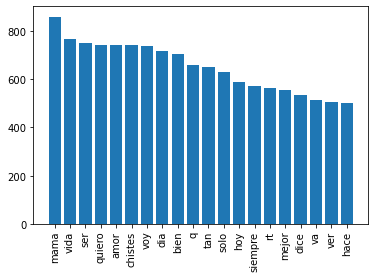

In [17]:
# Podemos graficar las 10 más fecuentes
top=20
top_words=[x[0] for x in word_count.most_common(top)]
plt.bar(range(top),[x[1] for x in word_count.most_common(top)])
#Las palabras mas fecuentes en el corpus brown
plt.xticks(ticks=range(len(top_words)),labels=top_words,rotation='vertical'); 

In [18]:
dict(word_count.most_common(top))

{'mama': 861,
 'vida': 766,
 'ser': 752,
 'quiero': 744,
 'amor': 744,
 'chistes': 743,
 'voy': 738,
 'dia': 720,
 'bien': 705,
 'q': 659,
 'tan': 651,
 'solo': 631,
 'hoy': 587,
 'siempre': 573,
 'rt': 564,
 'mejor': 556,
 'dice': 536,
 'va': 516,
 'ver': 505,
 'hace': 503}

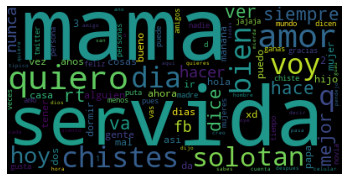

In [47]:
## Podemos obtener algo similar mediante una nube de palabras
## puede ver la documentacion de wordcloud en https://amueller.github.io/word_cloud/
wc=wordcloud.WordCloud()
wc.generate_from_frequencies(dict(word_count.most_common(100)))
plt.imshow(wc)
plt.axis("off")
plt.show()

El proceso anterior lo podemos replicar mediante el uso del modulo CountVectorizer de **scikit-learn**

In [20]:
from sklearn.feature_extraction.text import  CountVectorizer

In [21]:
vectorizer = CountVectorizer(tokenizer=my_tokenizer).fit(X)
# regresa una matriz dispersa donde cada fila tiene las frecuencias de cada token en el documento
bag_of_words = vectorizer.transform(data.text) 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [22]:
bag_of_words[2].data # solo tiene 9 palabras distintas 

array([3, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
#el tamaño del vocabulario
len(vectorizer.vocabulary_)

32100

In [24]:
#obtener la frecuencia de cada palabra
sum_words=bag_of_words.sum(axis=0) # sumas la frecuencia de todas las palabras
#obtenemos cada termino y lo mapeamos
words_count = Counter(dict([(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]))

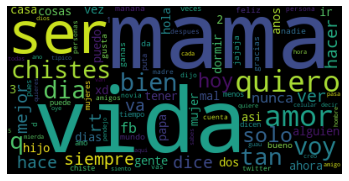

In [25]:
#Obtenemos una nube similar
wc=wordcloud.WordCloud()
wc.generate_from_frequencies(dict(words_count.most_common(100)))
plt.imshow(wc)
plt.axis("off")
plt.show()

### N-Gramas
En nuestro contexto un $n$-grama es una secuencia de $n$ tokens extraidos de un documentos. Estas secuencias nos permiten incluir en el vocabulario términos que están relacionados y aparecen juntos de forma recurrente. Por ejemplo la siguiente frase:

*Nueva York es la ciudad más poblada de los Estados Unidos*

Los $n$-gramas son importantes por que nos ayudan a conservar el significaco, por ejemplo los términios **Nueva York** y **Estados Unidos** adquieren diferente significado a si son separados. Si extendemos el vocabulario mediante la inclusión del $n$-gramas nuestro sistema de procesamiento de lenguaje natural podra retener parte del contexto (orden y significado) en el texto.

Podemos especificar el uso de $n$-gramas con la variable `ngram_range` se proporciona mediante el tuple (min, max). Donde  *min*  y *max* especifican rango de $n$-valores para diferentes $n$-gramas de palabra. Se utilizarán todos los valores de $n$ tales que $min_n$ <= $n$ <= $max_n$. Por ejemplo, un ngram_range = (1, 1) significa solo unigrams, (1, 2) significa unigrams y bigrams, y (2, 2) significa solo bigrams. 

In [26]:
vectorizer2grams = CountVectorizer(tokenizer=my_tokenizer,ngram_range=(2,2)).fit(X)
bag_of_words2grams = vectorizer2grams.transform(X) 
sum_words2grams=bag_of_words2grams.sum(axis=0) 
words_count2grams = dict([(word, sum_words2grams[0, idx]) for word, idx in vectorizer2grams.vocabulary_.items()]) 
words_count2grams=Counter(words_count2grams)

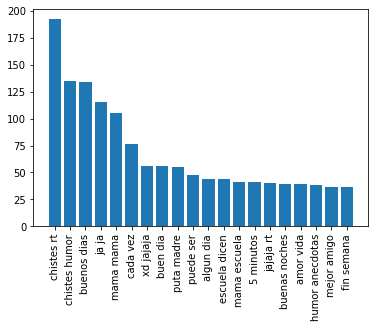

In [27]:
top=20
top_words=[x[0] for x in words_count2grams.most_common(top)]
plt.bar(range(top),[x[1] for x in words_count2grams.most_common(top)])
#Las palabras mas fecuentes en el corpus brown
plt.xticks(ticks=range(len(top_words)),labels=top_words,rotation='vertical'); 

### TF-IDF

**TF-IDF** es el acrónimo para `Term Frecuency Inverse Document Frecuency`. TF se refiere a la frecuencia de un  termino en un documento, mientras que IDF  implica que TF será pesado en base a la frecuencia de ese mismo termino en toda la colección (una división).

Aun cuando el conteo de palabras es útil, por si solo no dice mucho sobre la importancia de cada palabra en el documento en relación con el resto de los documentos del corpus. Si pudiera descubrir esa información, podría comenzar a describir documentos de forma `global`  dentro del corpus. Suponga que tiene una colección de libros de historia. Es muy probable que la palabra `historia` ocurrirá muchas veces en cada libro (documento), dado que ya sabemos que son libros de historia, ese término no aporta información. Por otro lado términos como `lenguaje` o `electrónica` podrían no ser frecuentes  dentro del corpus, debido a lo anterior serían importantes para caracterizar esos documentos.

Para poder considerar la situción anterior, introduciremos el conceptos de frecuencia inversa de documentos (IDF) Note que tenemos dos tipos de frecuencia, está puede determinarse por documento o bien en todo el corpus. Con la frecuencia inversas (IDF) estaríamos identificando que tan extraño es que un termino determinado aparezca en un documento. Si un token se repite muchas veces en un documento, pero es poco frecuente en el resto del corpus, se podría asumir que es importante específicamente para ese documento.

La frecuencia inversa de un término es la relación entre el número total de documentos y el número de documentos que contienen ese token. 

Dado que IDF usualmente indica que existe una diferencia muy grande,  en terminos que son relativamente igual de probables. Es decir , que aún cuando ocurren un número similar, la palabra más frecuente tendrá una frecuencia exponencialmente más alta que la menos frecuente.  Por lo que se hace un escalando todas las frecuencias de palabras (y frecuencias de documentos) con la función $\log()$ (i.e. la función inversa de un exponencial). Esto asegura que palabras que tienen frecuencias similares no difieran exponencialmente en frecuencia. Esto abona que la distribución de frecuencias de palabras usando TF-IDF sea más uniforme. Por lo tanto, IDF debe usar el logaritmo de la probabilidad original de que aparezca en uno de los documentos (lo mismo para la frecuencia). Lo anterior lo podemos sumarizar como:


$$\mathit{tf}(t,d)=\frac{\mathit{numero\_de\_veces\_que\_ocurre\_t\_en\_d}}{\mathit{numero\_de\_terminos\_en\_d}}$$ 

$$\mathit{idf}(t,D)=\log\frac{\mathit{numero\_de\_documentos}}{\mathit{numero\_de\_documentos\_que\_contienen\_}t}$$ 

$$\mathit{tfidf}(t,d,D)=\mathit{tf}(t,d)*\mathit{idf}(t,D)$$

donde $t$ representa un token, $d$ un documento y $D$ un corpus de documentos.

Así, cuantas más veces aparezca una palabra en un documento, TF y TF-IDF aumentan. Al mismo tiempo, a medida que aumenta el número de documentos que contienen esa palabra, el IDF  disminuirá y TF-IDF también lo hará. Lo que hace TF-IDF es dar un pesado que ayuda a relacionar un término con un documento específico en un corpus, asignando un valor numérico a la importancia de esa palabra en el documento, dado su uso dentro de todo el corpus.

La libreía **scikit-sklearn**  Ya cueta con una librería que permite general VSM tf-idf. Está librería tiene una amplia gama de parámetros que pueden ajustarse, los cuales vamos optimizar mediante diferentes técnicas de optimización. Puede consultar todos los parámetros del vectorizador en:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfidf = TfidfVectorizer(tokenizer=my_tokenizer)
vec_tfidf.fit(X)

TfidfVectorizer(tokenizer=<function my_tokenizer at 0x7f9ff256c1f0>)

In [29]:
def nube_de_palabras(data,vectorizer=CountVectorizer,n=1):
    vectorizer = vectorizer(tokenizer=my_tokenizer,ngram_range=(n,n)).fit(data)
    bag_of_words = vectorizer.transform(data) 
    sum_words=bag_of_words.sum(axis=0) 
    words_count = dict([(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]) 
    words_count=Counter(words_count)
    wc=wordcloud.WordCloud()
    wc.generate_from_frequencies(dict(words_count.most_common(100)))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return bag_of_words
    

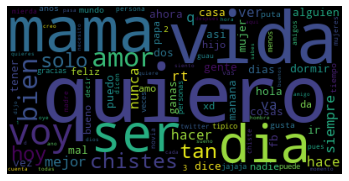

In [30]:
bow=nube_de_palabras(X,TfidfVectorizer) #generamos la nube de palabras con los pesos tfidf

# Análisis semántico

Los vectores TF-IDF (términos frecuencia-vectores de frecuencia inversa del documento) pueden ser utilizados para  determinar la importancia de las palabras en un fragmento de texto. Así como para calcular la importancia de cada palabra para el significado general de un fragmento de texto en una colección de documentos. 
Los valores de `importancia` de TF-IDF, también pueden ser calculados para secuencias cortas de palabras, es decir para $n$-gramas. Sin embargo los sistemas de NLP quiere ir más allá, se desea que una máquina sea capaz de comprender el `significado` de las palabras.

Una de la primeras formas que se utilizaron es el denominado análisis semántico latente (latent semantic analysis LSA). El uso de LSA, no solo permite representar el significado de las palabras como vectores, sino que permite que las usarlas para representar el significado de documentos completos, es decir el tópico del que trata el documento.

En esta sección, se presentarán los que denominaremos vectores semánticos o de tópico/tema. Se obtienen mediante el uso TF-IDF para calcular `índices` (scores) de tema que componen las dimensiones de los vectores de tópico. Lo anterior se basa en  el uso de la correlación de frecuencias de términos normalizados entre sí para agrupar palabras que consitutirán un tema.
Los vectores de tópicos de pueden utilizar para identificar documentos en función de su significado: búsqueda semántica. La mayoría de las veces, la búsqueda semántica es mejor que la búsqueda por palabras clave.  La búsqueda semántica es capaz de obtener resultados incluso cuando no se incluyen los términos exactos en la consulta.

Mediante el uso de los vectores semánticos para identificar las palabras y n-gramas que mejor representan el tópico de una sentencia, documento o colección de documentos (corpus). Con los vectores semánticos es posible comparar que tan `similares` en siginificado son dos elementos (sentencias, documentos).

## Frecuencia de términos  y pesado  de tópicos

Los vectores TF-IDF se generar mediante el conteo de las palabras en un documento, cada términos debe coincidir de fomar exacta para se contenado en la misma palabra (al menos así es cuando no se utiliza steming o lematización). Por lo tanto, los términos que tienen el mismo significado pero se escriben diferente  tendrán representaciones de vectoriales TF-IDF completamente diferentes. Es por ello que las búsquedas por palabra clave  pueden exihibir un desempeño pobre en representaciones basada en frecuencia de términos.

Meidante el uso de stemming/lematización, la palabras que comparten una misma raíz se agrupan en un sola término, con lo cual de obtienen colecciones de palabras con grafías similares y, a menudo, significados similares. La etiqueta de cada colección de palabras reemplaza en la lista de tokens a las palabras originales.

El enfoque previo solo garantiza que palabras escritas `de manera similar` se unifican en un solo token, pero no necesariamente garantiza que sus significados sean similares. Ni tampoco puede ser utilizada para emparejar la mayoría de los sinónimos. Esto ya que los sinónimos suelen diferir en más formas que las terminaciones de las palabras con las que se ocupan la lematización y stemming. Peor aún, la lematización/steaming a veces agrupan erróneamente antónimos, palabras con significado opuesto.

Derivado de lo anterior puede ocurrir que dos fragmentos de texto que hablan sobre lo mismo pero usan palabras diferentes no serán identificados como  `similares/cercanos` entre sí en un espacio vectorial TF-IDF lematizado. Además, es común,  que dos vectores TF-IDF que utilizan derivaciones que son `cercanos` entre si, no necesariamente tienen un significado similar. 


## Vectores de  tópicos(tema)

La estadística de palabras obtenidas por la representación TF-IDF, nos permite realizar operaciones matemáticas. Sin embargo, esas opercaiones nodicen mucho sobre como están relacionados los significados de las sentencias. También es posible calcular las representaciones TF-IDF palabra a palabra (vectores de co-ocurrencia o correlación de palabras) multiplicando la matriz TF-IDF por sí misma. Pero el `razonamiento vectorial` con estos vectores escasos y de alta dimensión no funciona bien. Las operaciones con estos vectores entre sí, no representan bien un concepto, palabra o tópico existente. 

En particular, nos  gustaría representar ese significado con un vector que al diferencia de un vector TF-IDF sea mas compacto (menor dimensión) y con más significado. A estos vectores de significado se les conoce `vectores palabra-tema`. Cuando estos vectores se crean por documento se les denomina `vectores de documento-tema`. Podemos referirnos a ellos indistitamento como `vectores de tema` o `vectores de tópico`. Estos vectores temáticos pueden ser compactos o de alta dimensión como desee.

Lo vectores de tópico a defierencia de TF-IDF perminten que la operaciones como sumas y diferencias representen una relación entre el significado de los elementos implicados. Es decir, podemos utilizar las distancias entre los vectores de tema para realizar  agrupación de documentos o búsqueda semántica. Mientras que TF-IDF, permite  agrupar y buscar usando palabras clave.

Partiendo de que se obtiene un vector palabra-tema para cada palabra en su léxico (vocabulario). Es posible calcular el vector de tema para cualquier documento nuevo simplemente sumando todos sus vectores de tema de palabra.

Sin embargo, obtener una representación numérica de la semántica (significado) de palabras y oraciones puede ser complicado. Esto es especialmente cierto para los idiomas `difusos` como el inglés o el español, que tiene varios dialectos y múltiples interpretaciones diferentes de las mismas palabras. Este concepto de palabras con múltiples significados se llama polisemia:

- **Polisemia**: es la existencia de palabras y frases con más de un significado.

A continuación enumeramos algunas formas en las que la polisemia puede afectar la semántica de una palabra o enunciado:

- Escritos:
    - *Homónimos*: palabras con la misma ortografía y pronunciación, pero con diferentes significados.
    - *Zeugma* : uso de dos significados de una palabra simultáneamente en la misma oración 

- Voz
    - *Homógrafos* : las palabras se escriben igual, pero con diferentes pronunciaciones y significados
    - *Homófonos*:  palabras con la misma pronunciación, pero diferentes deletreos y significados 

LSA puede lidiar con todos fenómenos polisemicos menccionados. Como ejemplo consider  las siguientes frases:
- `... él tuvo que cortar el tubo ...`
- `Evita evita la confrontación`
- `Grabe este grave asunto`

El problema al que no enfretamos es el reducir un vector TF-IDF de alta dimensión (decenas de miles de términos) a un vector unas pocas dimensiones (unas decenas). Para resolverto debemos encontrar esas dimensiones (palabras) que en conjunto representan un `tópico/tema` y sumar sus valores TF-IDF para crear un nuevo vector que representa la `relevancia` de ese tema en un documento dado. Una vez indentificados, podríamos ponderarlos por lo importantes que son para el tema, incluso podrían tener pesos negativos para las palabras que reducen la probabilidad de que el texto trate sobre ese tema. 

## Pesado de tópicos

Deseamos que un algoritmo sea capaz de identificar qué palabras van juntas o qué significan. El lingüista británico J. R. Firth, estudió las formas en que se puede estimar lo que significa una palabra o morfema. 
En 1957 le dio una pista sobre cómo calcular los temas para las palabras "Puedes conocer una palabra por las que la acompañan" ¿Recuerda el contexto de los word-embeddings?

Entonces, como determinamos la compañia de una palabra. El enfoque más simple es calcular la matriz de co-ocurrencias como ya lo hicimos con la bolsa de palabras (BOW) y los vectores TF-IDF.  Podemos hacerlo mejor mediate el uso de LSA para analizar la matriz TF-IDF para agrupar palabras en temas. También funciona en vectores de bolsa de palabras, pero los vectores TF-IDF dan usalmente mejores resultados.

Además LSA también permite optimizar los tópicos y mantener la diversidad en las dimensiones; por lo que cuando se utiliza el modelo de tópicos en lugar del vocabulario originale, se mantiene gran parte del significado (semántica) de los documentos. El número de temas que se requieren para que un modele semántico capture el significado es mucho menor que la cantidad de palabras en el vocabulario de sus vectores TF-IDF. Por lo tanto, a menudo se hace referencia a LSA como una técnica de reducción de dimensiones (si conoce PCA, LSA es un PCA sobre representaciones de documentos). 

Dos algoritmos similares a LSA, con aplicaciones de PLN son: Linear discriminant analysis (LDA) y Latent Dirichlet allocation (LDiA). Mientras que LDA descompone un documento en un único tema. LDiA se parece más a LSA porque puede dividir documentos en tantos temas como desee. 


##  Análisis semántico latente (LSA)

LSA se basa en una de las técnicas más antigua y más ampliamente utilizada para la reducción de dimensiones, la descomposición de valores singulares (Singular Value Descomposition SVD).  SVD se ha utilizado desde antes de que existiera el aprendizaje automático. La  técnina consiste en descomponer una matriz en tres matrices cuadradas, una de las cuales es una matriz diagonal.

Una matriz se puede invertir mediante el uso de SVD, la matriz se descompone en tres matrices cuadradas más simples, despues se transponen las matrices y finalmente se multiplican. Es facil imagenes, todas las aplicaciones de un algoritmo que proporciona una forma eficiente para invertir matrices grandes. SVD es ampliamente aplicado a problemas de ingeniería e incluso se utiliza en ciencia de datos para sistemas de recomendación basados.

### SVD y LSA

El uso de SVD, perminte dividir una matriz de documentos TF-IDF en tres matrices más simples. Mediante el uso de las matrices obtenidas se pueden recosntruir la matriz original al multiplicarlas. En terminos simples lo que se hace es factorizar un matriz en tres matrices mas simples. Además la tres matrices obtenidas mediante SVD revelan propiedades de la matriz TF-IDF original que pueden ayudar simplificarla. Por ejemplo, podemos truncar esas matrices (eliminar algunas filas y columnas) antes de volver a multiplicarlas, como resultado se ontendía un modelo de espacio vectorial de menores dimensiones.

El uso de las matrices truncadas no rescontruye exactamente la matriz orinignal, sino más bien es una aproximáción, la cual es un muchos caso puede resultar mejor que la representación original. Lo anterior debido a que la nueva representación contiene la `semántica latente` de los documentos. Debido a lo anterior es que SVD es frecuentemente utilizada en aplicaciones de compresión. La mejor respresentación en es parte debido a que al capturar la escencia se tiene una reducción del ruido presente en los datos. 

En el caso de PLN, el uso de LSA permite "descubir" la semántica, o el significado oculto de las palabras.  En este sentidos podemo decir que LSA es una técnica que permite encontrar la transformación `óptima` de un conjunto de vectores TF-IDF o BoW. Para muchos problemas de alta dimension la mejor transformación es alinear los ejes (dimensiones) en sus nuevos vectores con la mayor "extensión" es decir los que presentan una mayor varianza en la frecuencia de las palabras. Posteriormente se  pueden eliminar todas las dimensiones en el nuevo espacio vectorial que no contribuye significativamente. Al uso de SVD de esta manera se le conoce como descomposición de valores singulares truncado (Truncate SVD).

Cuando aplicamos LSA,  SVD se utiliza para encontrar las combinaciones de palabras que juntas, representan la mayor variación en los datos. Durante el proceso, los vectores TF-IDF puende ser rotados para que las nuevas dimensiones (vectores base) se alineen con las direcciones de varianza máxima. Los “vectores base” representan los ejes del nuevo espacio vectorial y son análogos a los vectores de tópicos. Cada una de las dimensiones resultantes representan una combinación de las frecuencias de palabras en lugar de la frecuencia de una palabra a la vez. En resumen,  las dimensiones resultates son combinaciones ponderadas de palabras que componen los tópicos que se utilizan a lo largo de su corpus.

Una máquina no es capaz de "entender" lo que significan las combinaciones de palabras, solo aprende que usualmente aparecer juntas. Cuando ve muchas palabras como "perro", "gato" y "iguana", las agrupa en un tema. No sabe que un nombre apropiado para ese tópico podría ser `mascotas`. Puede incluir muchas palabras como "veterinario" y "arena" en el mismo tema, o incluso palabras que significan lo opuesto entre sí. Si ocurren juntos muchos en los mismos documentos, LSA les dará puntajes altos para los temas similares. Sin embargo, la descripción o nombre del tema  depende de la interpretación humana. 

El darle un nombre un tópico no es necesario para poder aprovecharlo en diferentes tareas. De igual forma como no no analizamos los miles de dimensiones en los vectores BoW o TF-IDF, no  se tiene que comprender el significado todos sus temas para realizar  operaciones matemáticas con esta nueva transformacion. 

LSA  nos permite  identificar las dimensiones del  vector importantes para la semántica (significado) de los documentos. Por lo que podemos descartar aquellas dimensiones (tópicos) que contribuyan poco a la variación entre documentos. Si cada documento tiene aproximadamente la misma proporcion de algún tema y este no ayuda a diferenciar los documentos, entonces podemos deshacernos de él. Y eso ayudará a generalizar la representación vectorial para que funcione mejor cuando la utilicemos con documentos que no son parte del corpus de entrenamiento.

Esta generalización y compresión que realiza LSA logra lo que intentamos con el uso de las las palabras vacías o derivaciones. Pero la reducción de la dimensión LSA es mejor, porque es óptima. Retiene la mayor cantidad de información posible y no descarta ninguna palabra, solo descarta dimensiones (tópicos poco relevantes). LSA comprime el significado en menos dimensiones. Solo tenemos que retener las dimensiones de alta varianza, los temas principales de los que habla su corpus en una variedad de formas (con alta varianza). Y cada una de estas dimensiones se convierte en los tópicos del corpus, con una combinación ponderada de todas las palabras capturadas en cada tema.

#### El método SVD
SVD permite  descomponer cualquier matriz en tres matrices que pueden utizarse para recoustruir la matriz original. Lo anterior es simalara descomponer un número en sus factores primos. Solo que en este caso no se buscan valores escalares, si no más bien 3 matrices de números reales. 
Las matrices obtenidas mediante SVD tienen algunas propiedades matemáticas útiles que  nos ayudan a realizar unp proceso de reducción dla reducción, así como a identificar los tópicos presentes en la colección de doucmentos. 

Al aplicarse SVD sobre una matriz de BoW o TF-IDF se encuentran simultáneamente la correlación del uso de términos entre documentos, así como la correlación que existe entre los documentos del corpus. Además también se determinan las combinaciones lineales de los términos que presentan la mayor variaza en el corpus. Las combinaciones lineales represeantan lo temas presentes en la colección. Los matrices (factores) obtenidos por SVD puden ser utilizados para realizar una transformación que resulta en uan reducción que dimensión a la vez que se conserva la información semántica de los documentos SVD agrupa los términos que tienen una alta correlación entre sí (identificado cuales ocurren mucho juntos en los mismos documentos) y también varían mucho "juntos" en el corpus.  Los vectores obtenido, son vectores de tópico, el cual puede entenderse como un resumen o generalización de lo que trata el documento.

Ahora pongamos SVD en notación matemática:

$$W_{M \times N}=U_{M \times l} S_{l \times l} V_{l \times N}^T,$$

donde $N$ es el tamaño del vocabulario, $M$ el número de documentos en el corpus y $l$ es el número de tópicos presentes en el corpus (es decir $l=M$), que sería equivalente al número de palabras. Lo que haremos será utilizar las matrices $U, S$ y $V$ para identificar cuales combinaciones de esos tópicos son las más `relevantes`.


##### La matrix U

Esta matriz es la más para el proceso de análisis semántico. La matriz $U$ contiena la relación `tópico-término` es decir el contexto de las palabras (quienes son su compañia). U es conociada como la matriz de  `vectores singulares izquierdos` porque contiene vectores de fila que deben multiplicarse por la izquierda; $U$ captura la  correlación cruzada entre palabras y temas en el mismo documento. Esta matriz podemos tuncarla para reducir el número de columnas. Ahora veamos el ejemplo para los vectores tfidf .

##### Valores singulares $S$
$S$ contiene los tópicos “valores singulares” y es un vector que del tamaño del vocabulario. Los valores singulares dicen cuánta información es capturada por cada dimensión en su nuevo espacio vectorial semántico (tópico). Este vector representa una matriz diagonal es decir tiene valores distintos de cero solo a lo largo de la diagonal principal. Al regresar un vector `numpy` ahorra espacio al devolver los valores singulares como un vector

##### Vectores singulares $V^T$ 

La matriz $V^T$ contiene los "vectores singulares derechos" como las columnas de la matriz documento-documento (30x30 para el ejemplo). Esta contiene el significado compartido entre documentos, porque mide la frecuencia con la que los documentos utilizan los mismos temas en el modelo semántico de los documentos. Tiene el mismo número de filas ($l$) y columnas que los documentos.

### SVD truncado para análisis semántico

En nuestro caso utilizaremos TruncateSVD implementado en `scikit-learn`. Este es un enfoque  directo de LSA que puede manejar matrices dispersas, por lo que si se está trabajando con grandes conjuntos de datos, debería preferir el uso de SVD sobre PCA. Mediante el uso de  TruncatedSVD se divide la matriz TF-IDF en las 3 matrices $U$, $S$ y $Vt$ y posteriormente se descartan las dimensiones que contienen menos información. Las dimensiones desechadas representan los tópicos que presentan la menor varianza en el corpus. Ahora utilizaremos TruncateSVD para retener los 5 tópicos más relevantes de nuestros tweets de humor.

In [31]:
from sklearn.decomposition import TruncatedSVD

In [32]:
vectorizer = TfidfVectorizer(tokenizer=my_tokenizer).fit(X) # TF-IDF modelo
vtfid=vectorizer.transform(raw_documents=X)

In [33]:
nt=8
svd = TruncatedSVD(n_components=nt, n_iter=100)
vectores_de_topicos_svd = svd.fit_transform(vtfid)
topicos=[f'topico{str(i+1).zfill(2)}' for i in range(nt)]
cols_num,terms_bow=zip(*sorted(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys()))) #

In [34]:
vectores_de_topicos_svd.shape

(24000, 8)

In [35]:
# El peso de cada palabra en cada uno de los topicos (ordenado alfabeticamente) 
componentes=pd.DataFrame(svd.components_.T,columns=topicos,index=terms_bow)
componentes.head()

,topico01,topico02,topico03,topico04,topico05,topico06,topico07,topico08
!,0.000394,-0.000155,-0.000294,0.000310,0.000055,-0.000109,0.000086,-0.000358
(,0.000729,-0.000146,-0.000267,-0.001250,0.001426,-0.000256,0.002143,-0.000310
",",0.000031,-0.000010,0.000004,-0.000013,0.000004,-0.000013,-0.000005,-0.000006
-,0.000062,-0.000020,0.000009,-0.000027,0.000007,-0.000027,-0.000011,-0.000012
.,0.000031,-0.000010,0.000004,-0.000013,0.000004,-0.000013,-0.000005,-0.000006


In [36]:
# podemos ver los terminos de mayor peso en cada tópico
componentes.topico01.sort_values(ascending=False)[:10]  

quiero    0.249218
mama      0.233939
dia       0.202034
ser       0.187092
vida      0.185101
voy       0.178719
amor      0.173375
bien      0.169550
mejor     0.136604
tan       0.132944
Name: topico01, dtype: float64

Cada uno de los 24k tweet pertenecerá al tópico que tenga el mayor peso sus en  su respectivo vector de tópico. Esto lo podemos obtener como sigue:

(array([18346.,   690.,  1273.,   844.,   611.,   939.,   618.,   679.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

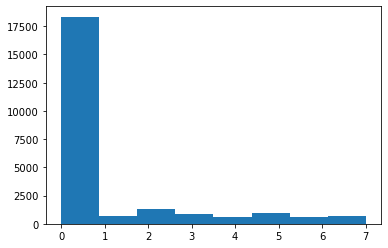

In [37]:
tweet_topico=np.argmax(vectores_de_topicos_svd,axis=1) #a que topico pertenece cada tweet
plt.hist(tweet_topico, bins=8)

Como podemos ver casi todos los documentos pertenecen al tema 0. Podríamos analizar y generar nubes de palabras para cada tópico y definirlo por los $k$ términos que más se repiten.

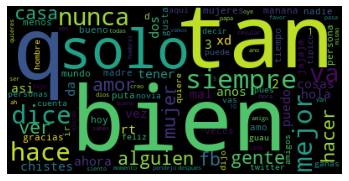

<18346x27350 sparse matrix of type '<class 'numpy.int64'>'
	with 131567 stored elements in Compressed Sparse Row format>

In [48]:
nube_de_palabras(X[np.argwhere(tweet_topico==0).flatten()])

## Latent Dirichlet allocation (LDiA)

LDiA (Latent Dirichlet allocation) es otra técnica emparenteada con LSA que puede ser utilizada para generar vectores que capturan la semántica de una palabra o documento. LDiA utiliza un algoritmo estadístico no lineal para agrupar palabras. Como resultado, generalmente es más lento que los enfoques lineales como LSA. A menudo, esto hace que LDiA sea menos práctico para muchas aplicaciones del mundo real. No obstante, las estadísticas de los temas son más similares a la intuición humana. Por lo que, los tópicos obtenidos mediante LDiA a menudo serán más fáciles de interpretar. Además LDiA puede usarse para problemas un solo documento, en el cual ser obtendría un resumen del mismo. El documente genera un corpus, donde cada sentencia es un documento de la colección. Esa idea es la que implementa gensim y otros paquetes que proporcionan un modulo para dentificar las oraciones centrales de un documento. Las sentencias obtenidas se pueden unir para crear un resumen generado por una máquina. Para la mayoría de los problemas de clasificación o regresión, normalmente es mejor utilizar LSA.

Aún cuando LSA debería ser la primera opción para la mayoría de modelos de tópicos, búsqueda semántica o motores de recomendaciones basados en contenido. LDiA puede dar resultados mejores en algunas situaciones.
LDiA es similar a LSA, pero a diferencia de LSA, LDiA asume que las frecuencias de terminos tienen una distribución de Dirichlet.

LDiA crea un modelo de espacio vectorial semántico utilizando un enfoque mas similar a como lo haría una persona utilizando su intuición. La combinación de temas de un documento se determina mediante la combinación de palabras en cada tópico según el tema al que se asignaron esas palabras. Lo anterior hace que un modelo LDiA sea mucho más fácil de interpretar, porque las palabras asignadas a los temas y los temas asignados a los documentos tienden a tener más sentido que para los modelos LSA. 



LDiA asume que cada documento es una combinación lineal de un número arbitrario de temas los cuales se seleccionan para entrenar el modelo LDiA. LDiA también asume que cada tema puede ser representado por una distribución de palabras (frecuencias de tokens). Se parte de la idea de que la probabilidad o el peso de cada uno los temas sea parte de un documento, así como de la probabilidad de que una palabra sea asignada a un tema están definidad por una distribución de probabilidad de Dirichlet.

### LDiA para modelado de tópicos

Como ya hemos mencionado los temas determinado utilizando LDiA tienden a ser más comprensibles para los humanos. Esto se debe a que a las palabras que aparecen juntas con frecuencia se les asignan a los mismos temas, tal y como lo esperariamos. Por otro lado, LSA intenta mantener la separación(varianza) entre los datos, mientras que LDiA intenta mantener unidos los términos que están unidos en el corpus. Las dos estrategias optimizan cosas diferentes  Para mantener juntos los vectores de alta dimensión en el espacio de dimensión inferior, LDiA tiene deformar  el espacio (y los vectores) de formas no lineales.

Ahora apliquemos LDiA a nuestro conjunto de datos. Primero calcularemos los vectores de frecuencia y luego algunos vectores de temas para cada tweet en el corpus. Asumimos el uso 16 topicos. Mantener un número bajo de temas (dimensiones) puede ayudar a reducir el sobre-aprendizaje. 
Dado que LDiA utiliza vectores  BoW sin procesar en lugar de vectores TF-IDF normalizados. Calcularemos los vectores BOW usando scikit-learn. 

In [39]:
np.random.seed(3)
counter = CountVectorizer(tokenizer=my_tokenizer)
vsm=counter.fit_transform(raw_documents=X)
cols_num,terms_bow=zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
tweets_bows=pd.DataFrame(vsm.toarray(),index=[f't{i}' for i in range(len(X))], columns=terms_bow)

In [40]:
tweets_bows

,!,(,",",-,.,...,/,//,/_,/__,...,zuper4rm3p,zuperman,zurro,zuv3n,zygyrs,zzi,zzzz,zzzzz,zzzzzzz,|
t0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t23995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t23996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t23997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t23998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora utilicemos LDiA sobre el corpus de entrenamiento

In [41]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA # toma unos minutos minutos
np.random.seed(3)
ldia = LDiA(n_components=nt)

In [42]:
vectores_de_topicos_ldia=ldia.fit_transform(tweets_bows)# toma unos minutos minutos

In [43]:
#  Matrix palabra topico
componentes_ldia = pd.DataFrame(ldia.components_.T, index=terms_bow, columns=['topico{}'.format(i+1) for i in range(nt)])

In [44]:
componentes_ldia.topico4.sort_values(ascending=False)[:10]

mama      428.575995
siento    136.485738
hola      131.165131
hijo      119.233527
dios      105.180588
va        103.682787
ano       102.863271
papa      102.851889
aqui      102.340370
ahora      97.569940
Name: topico4, dtype: float64

(array([3415., 2811., 3039., 2968., 3262., 2722., 2959., 2824.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

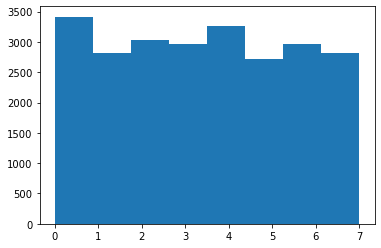

In [45]:
tweet_topico2=np.argmax(vectores_de_topicos_ldia,axis=1)
plt.hist(tweet_topico2, bins=8) # revisamos la pertenencia a cada tópico

los tweets estan más distrubuidos entre los distintos tópico.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


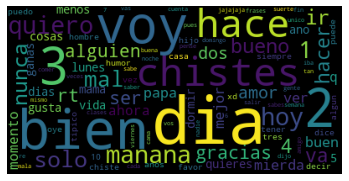

<3415x8087 sparse matrix of type '<class 'numpy.int64'>'
	with 24483 stored elements in Compressed Sparse Row format>

In [46]:
nube_de_palabras(X[np.argwhere(tweet_topico2==0).flatten()])

### Alternativas a LSA/SVD

El éxito de la descomposición de valores singulares para el análisis semántico y la reducción de dimensiones ha motivado el desarrollo de algorimtos mejorados. Aun cuando las mejoras estan enfocadas en problemas que no son  PLN, nada impidide que puedan utilizarse con ese próposito. Por lo tanto, puedes resultar de utilidad para el análisis semántico. Algunos de lo métodos reportados son:

- **Quadratic discriminant analysis (QDA)**. A diferencia de LDA, QDA realiza una transformación cuadrática. Esta transformación define un espacio vectorial que puede ser utilizado para discriminar entre diferentes clases. 
- **Proyección aleatoria**. Es una técnica de descomposición/transformación  similar a SVD, pero el algoritmo es estocástico, por lo que diferentes ejecuaciones obtienen diferente respuesta. Su naturaleza estocástica facilita su implementación en paralelo. Y en algunos casos (para algunas de esas ejecuciones aleatorias), puede obtener transformaciones que son mejores que las obtenidas mediante de SVD. 
- **Factorización matricial no negativa (NMF)**. Es una familia de algoritmos para la factorización de matrices. NMF tiene la particularidad de que los factores obtenidos no tienen elementos negativos. Esta no negatividad hace que las matrices resultantes sean más fáciles de inspeccionar. 

## Referencias
[1] Lane, H., Howard, C., & Hapke, H. (2019). Natural Language Processing in Action Video Edition. Manning Publications.
[2] Borg, I., & Groenen, P. J. (2005). Modern multidimensional scaling: Theory and applications. Springer Science & Business Media. <br>
[3] Schölkopf, B., Smola, A., & Müller, K. R. (1997, October). Kernel principal component analysis. In International conference on artificial neural networks (pp. 583-588). Springer, Berlin, Heidelberg.<br>
[4] Talwalkar, A., Kumar, S., Morhri, M., & Rowley, H. A. (2013). Large Scale SVD and Manifold Learning.<br>
[5] WordCloud, https://amueller.github.io/word_cloud/ 

## Actividad

<div class="alert alert-success">

<h3>Análisis exploratorio de documentos de texto mediante LSA</h3><br>
    Utilizar LSA, LDiA para el ánalisis de temas  por clase (joke, no-joke), humor_mechanish y humor_rating(opcional) el dataset de tweets (humor.csv).
    <ul>
        <li>Generar la matriz de termino documento por clase y por humor_mechanish (tfidf y bag of words)</li>
        <li>Realice un análisis sobre las frecuencias(por clase y humor_mechanish) de términos sobre los vectore  TF-IDF y BoW. Utilice medidas estadísticas y nubes de palabras</li>
        <li>Realizar reducción de dimensión (utilice LatentDirichletAllocation y TruncateSVD)</li>
        <li>Elija un número de tópicos de al menos el mismo numero de humor_mechanish+1</li>
        <li>Determine el tópico de cada tweet y basado en los grupos obtenidos para cada tema, identifique las 10 palabras más frecuentes en cada tema.</li>
        <li>Determine si es posible identificar los temas en cada una de las clases y compare los resultados entre LSA y LDiA</li>
        <li>Realice un reporte. El documento deberá incluir las siguientes secciones:
        <ul>
            <li>Introducción</li>
            <li>Al menos una sección del análisis realizados y los resultados obtenidos.</li>
            <li>Conclusiones</li>
            <li>Referencias</li>
        </ul>
    </li>
    </ul>
    <b>Nota</b>: Subir un documento en formato pdf. Si utiliza estrategias adicionales por favor incluir las referencias. Si tienes alguna pregunta respecto al material o la actividad puedes ingresar al foro de dudas.
</div>